# SpectralDefocusCam Iterative Reconstruction Demo

In [24]:
import matplotlib.pyplot as plt
import scipy.io
import utils.helper_functions as helper
import utils.psf_utils as psf_utils
import utils.diffuser_utils as diffuser_utils
import inference, train
import PIL.Image as Image
import numpy, torch
import os
import glob

# Change this to GPU or CPU depending on your machine 
device = "cuda:0"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
if "cuda" in device:
    import cupy as np
else:
    import numpy as np

### View calibration data and image

In [26]:
psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
sample_data_path = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data"
calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_11_10_2023_2_preprocessed/calibration_matrix_450-810_30chan_stride12_avg12.mat"

#exp params
crop_center = [1000, 2000]
crop_size = [384, 384]
patch_size = [384, 384]#[256, 256]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

# calibration matrix
mask = diffuser_utils.load_mask(calib_mat_path_rel, crop_center, crop_size, patch_size)

# psfs (for visualization)
psf_stack = psf_utils.get_lsi_psfs(
    psf_path_rel, 
    blur_levels=num_ims,
    crop_size=crop_size[0], 
    dim=patch_size[0],
    ksizes=ksizes,
    use_first=True,
    exposures=exposures, 
    threshold=0.55,
    zero_outside=128,
    blurstride=1
)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]


In [27]:
#sim params
data_split = (0.7, 0.15, 0.15)
image_index = 13
sim_meas = True

# sample data
_, _, test_loader = inference.ds.get_data(1, data_split, sample_data_path, patch_size=patch_size)
img = test_loader.dataset.__getitem__(image_index)

calling subimage: (167, 207, [384, 384])


In [28]:
helper.plot_cube_interactive(img['image'].cpu().numpy().transpose(1,2,0))

FigureWidget({
    'data': [{'type': 'image',
              'uid': '48ffaf74-ad94-4e76-9fa1-f14aea7d3d77',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 4,  3,  0],
                           [ 3,  3,  0],
                           [ 3,  3,  0],
                           ..., 
                           [46, 39,  4],
                           [42, 35,  4],
                           [44, 37,  4]],
                   
                          [[ 4,  3,  0],
                           [ 3,  3,  0],
                           [ 3,  3,  0],
                           ..., 
                           [45, 37,  3],
                           [45, 38,  4],
                           [45, 38,  4]],
                   
                          [[ 3,  3,  0],
                           [ 3,  3,  0],
                           [ 3,  3,  0],
                           ..., 
                           [45, 37,  4],
                           [44, 37,  4],

In [29]:
helper.plt3D(mask, title="Spectral calibration matrix")
print(mask.shape)

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

(384, 384, 30)


### Initialize forward model

In [44]:
stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements

config = {
    "device": device,
    "mask_dir": calib_mat_path_rel,
    "psf_dir": psf_path_rel,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size[0],
            "exposures": exposures,
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": True,
            "adjoint": False,
            "spectral_pad": False,
            "roll": True
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 500,
        "prox_method": 'tv',
        "tau": 0.05,
        "tv_lambda": 0.003,
        "tv_lambdaw": 0.003,
        "lowrank_lambda": 0.000005,
        "print_every": 20
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

model = train.get_model(config, device=device)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 44.28it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
device =  None , using GPU and cupy
<class 'cupy.core.core.ndarray'> <class 'cupy.core.core.ndarray'>


## Run model with fista recon

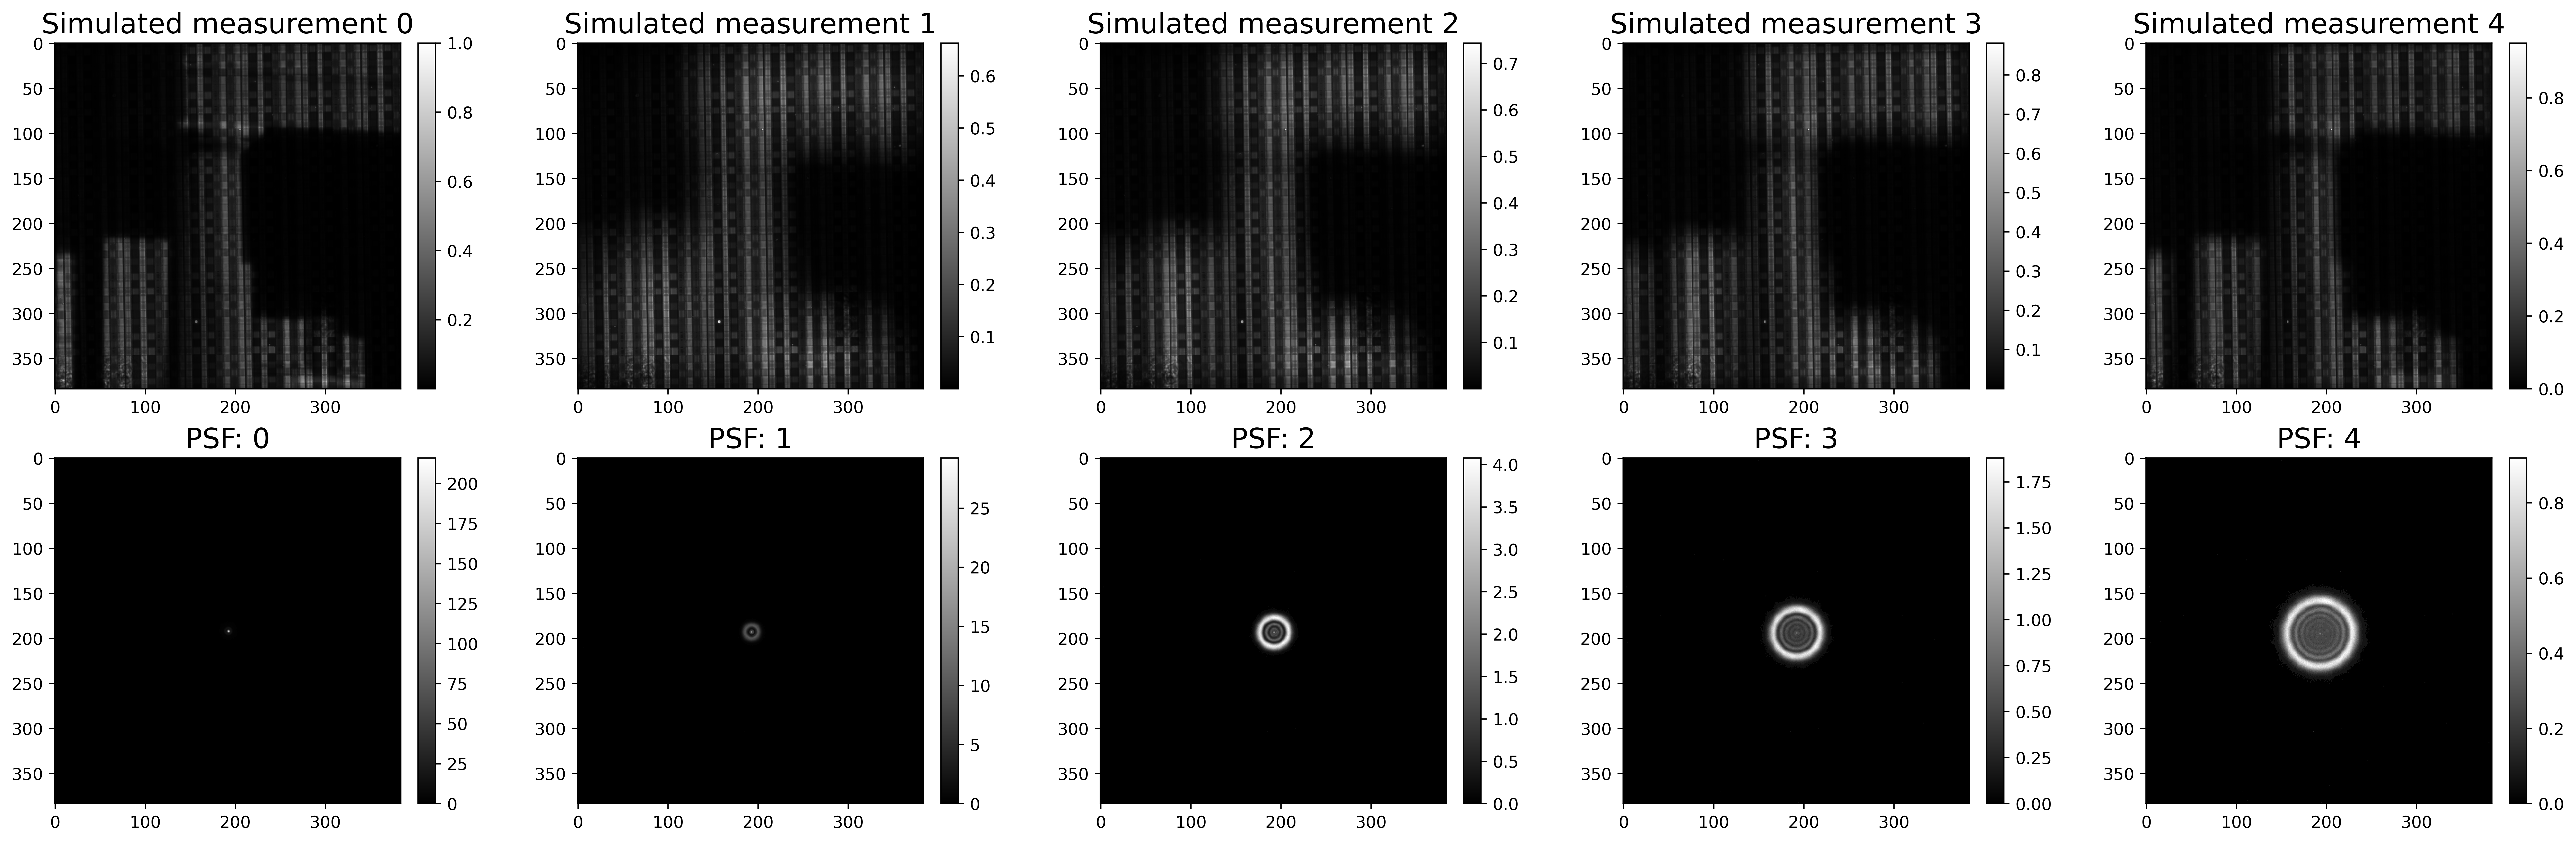

In [45]:
# Let's look at the simulated images and psfs
sim_output = model.model1(img['image'][None,None,...].to(device))[0,:,0,:,:]

psfs = model.model2.psfs.get()

num_cols = config["forward_model_params"]["stack_depth"]
fig, ax = plt.subplots(2,num_cols,figsize=(num_cols * 5.5, 8.5))

for i, im in enumerate(sim_output):
    img1 = ax[0][i].imshow(im.cpu().numpy(), cmap = "gray")
    fig.colorbar(img1, ax=ax[0][i], fraction=0.046, pad=0.04)
    img2 = ax[1][i].imshow(psfs[i], cmap = "gray")
    fig.colorbar(img2, ax=ax[1][i], fraction=0.046, pad=0.04)
    ax[0][i].set_title(f"Simulated measurement {i}", fontsize=17)
    ax[1][i].set_title(f"PSF: {i}", fontsize=17)
    
plt.show()

In [46]:
if sim_meas:
    measurement = img['image'].unsqueeze(0).to(device)
else:
    measurement = meas_stack.unsqueeze(0).to(device)

out = model(measurement)

IndexError: list index out of range

### Visualize Outputs

In [ ]:
recon = model.model2.out_img

# Visualize GT
if sim_meas:
    gt = img['image'].numpy().transpose(1,2,0)
    helper.plt3D(img['image'].numpy().transpose(1,2,0), title="Test hyperspectral image (ground truth)")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

In [ ]:


# Visualize in 3D scan
helper.plt3D(helper.pre_plot(recon, False), title="Spectral Reconstruction")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

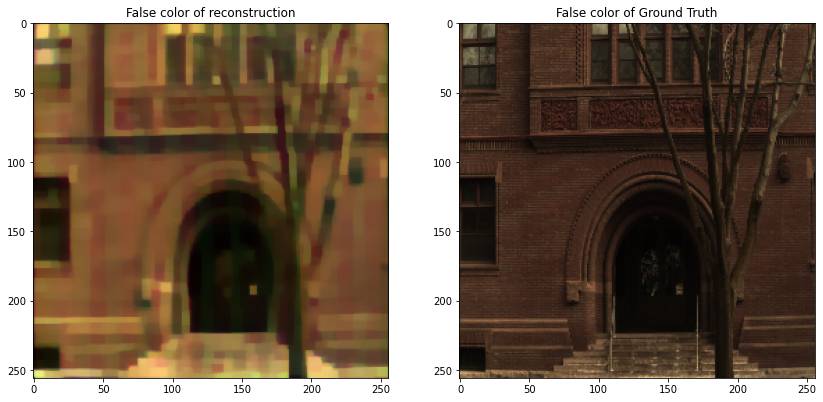

In [ ]:
# Visualize in false color
fc_mat = "/home/cfoley_waller/defocam/SpectralDefocusCam/utils/false_color_calib.mat"
fc_img = helper.pre_plot(helper.stack_rgb_opt_30(recon, opt = fc_mat), False)
gt_img = helper.pre_plot(helper.stack_rgb_opt_30(gt, opt = fc_mat), False)

fig, ax = plt.subplots(1,2,figsize= (14,7))
ax[0].imshow(fc_img)
ax[0].set_title("False color of reconstruction")
ax[1].imshow(gt_img)
ax[1].set_title("False color of Ground Truth")
plt.show()

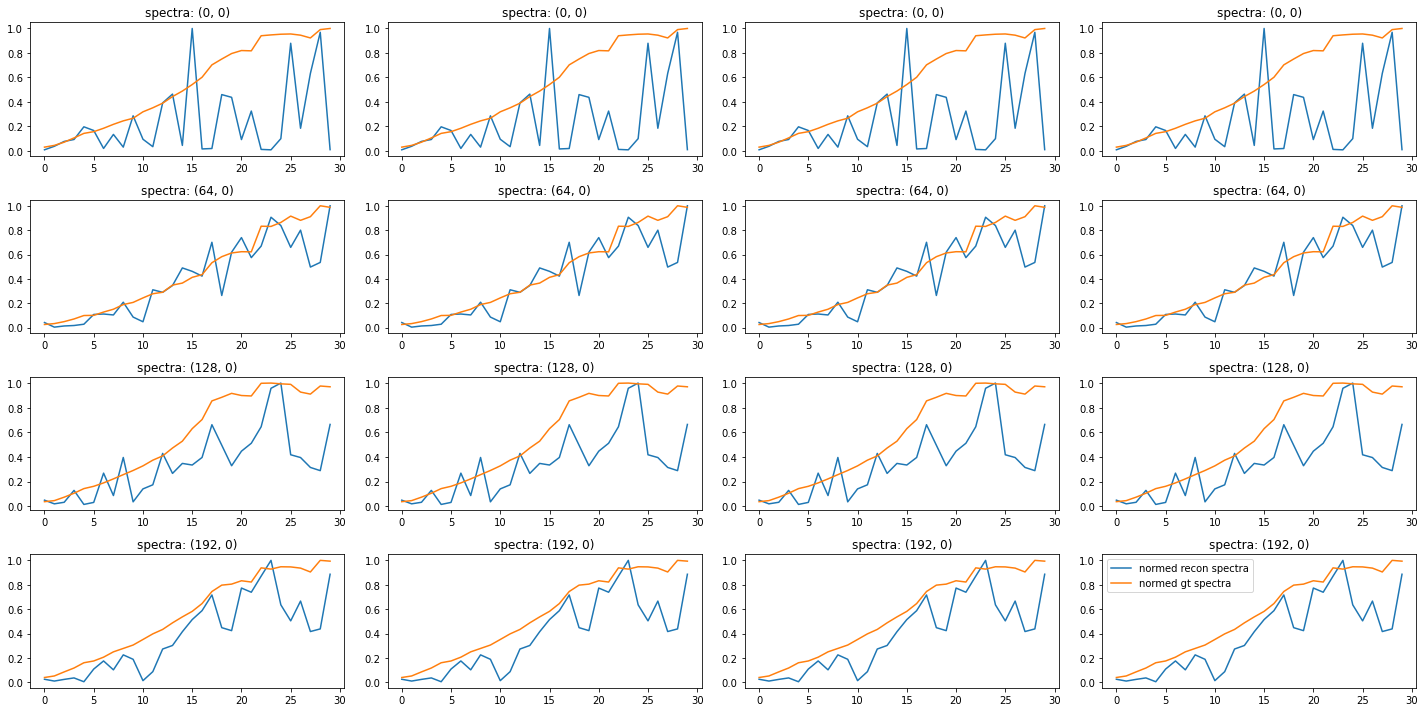

In [ ]:
# Visualize spectra

fig, ax = plt.subplots(4,4,figsize=(20,10))

for i in range(4):
    for j in range(4):
        x = (fc_img.shape[1] // 4) * i
        y = (fc_img.shape[2] // 4) * j
        ax[i][j].plot(recon[x,y,:]/numpy.max(recon[x,y,:]), label="normed recon spectra")
        ax[i][j].plot(gt[x,y,:]/numpy.max(gt[x,y,:]), label="normed gt spectra")
        ax[i][j].set_title(f"spectra: {x, y}")
plt.legend()
plt.tight_layout()
plt.show()

### Trying a trained model on experimental measurements

In [ ]:
config_path = "/home/cfoley_waller/defocam/SpectralDefocusCam/config_files/training/train_10_14_2023_stack3_sim_blur_r2attn.yml"
config = helper.read_config(config_path)
config["checkpoint_dir"] = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_10_14_2023_stack3_sim_blur_r2attn.yml/2023_10_15_00_17_43/saved_model_ep240_testloss_0.022517784631678035.pt"
model = train.get_model(config, device="cuda:0")